In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/data/ComVN30_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/data/ComVN30_test.csv')

In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2340 non-null   object
 1   open    2340 non-null   int64 
 2   high    2340 non-null   int64 
 3   low     2340 non-null   int64 
 4   close   2340 non-null   int64 
 5   volume  2340 non-null   int64 
 6   ticker  2340 non-null   object
dtypes: int64(5), object(2)
memory usage: 128.1+ KB


In [5]:
#Chuyển dữ liệu về kiểu date time
train_data['time'] = pd.to_datetime(train_data['time'])
test_data['time'] = pd.to_datetime(test_data['time'])

In [6]:
#set cột 'time' trở thành index và chọn 'close' sẽ là cột để dự đoán
train_series = train_data.set_index('time')['close']
test_series = test_data.set_index('time')['close']

#Thực hiện mô hình trên một mã chứng khoán

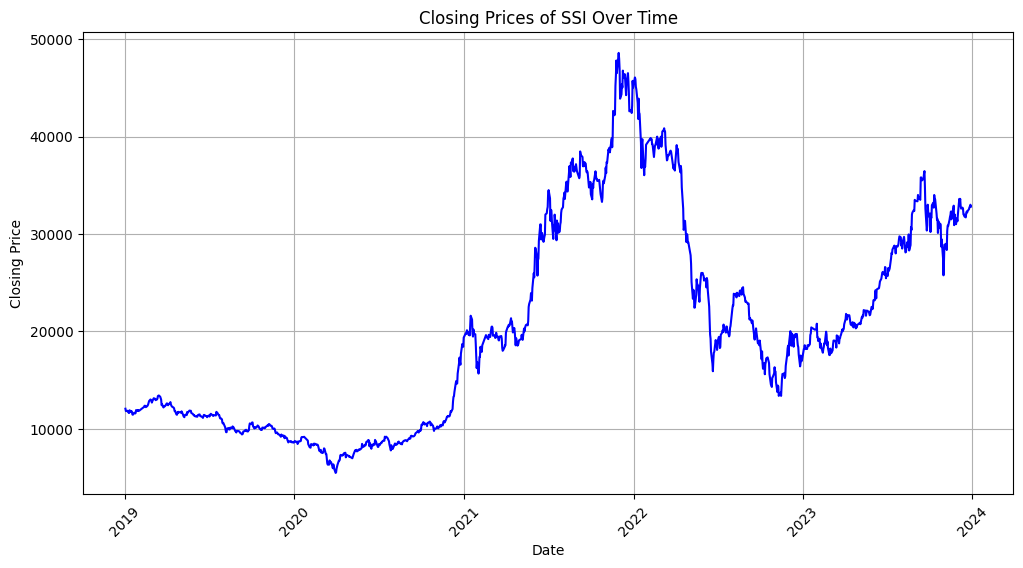

In [7]:
ssi_train = train_data[train_data['ticker'] == 'SSI']
ssi_test = test_data[test_data['ticker'] == 'SSI']

plt.figure(figsize=(12, 6))
plt.plot(ssi_train['time'], ssi_train['close'], linestyle='-', color='b')
plt.title('Closing Prices of SSI Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.show()

In [8]:
ssi_train_seri = ssi_train.set_index('time')['close']
ssi_test_seri = ssi_test.set_index('time')['close']

In [9]:
#Thực hiện kiểm tra tính dừng của tập dữ liệu
from statsmodels.tsa.stattools import adfuller

result = adfuller(ssi_train_seri)
print('ADF Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
if result[0] < result[4]["5%"]:
  print("Chuỗi dừng")
else:
  print("Chuỗi không dừng")

ADF Test Statistic: -1.075136
p-value: 0.724885
Critical Values:
{'1%': -3.4356133204636095, '5%': -2.8638642784217305, '10%': -2.5680074748794373}
Chuỗi không dừng


In [10]:
ssi_diff=ssi_train_seri.diff().dropna()
ssi_diff

,close
time,
2019-01-03,-240.0
2019-01-04,0.0
2019-01-07,30.0
2019-01-08,-160.0
2019-01-09,30.0
2019-01-10,-100.0
2019-01-11,280.0
2019-01-14,-160.0
2019-01-15,80.0


In [11]:
result = adfuller(ssi_diff)
print('ADF Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
if result[0] < result[4]["5%"]:
  print("Chuỗi dừng")
else:
  print("Chuỗi không dừng")

ADF Test Statistic: -14.024543
p-value: 0.000000
Critical Values:
{'1%': -3.4356133204636095, '5%': -2.8638642784217305, '10%': -2.5680074748794373}
Chuỗi dừng


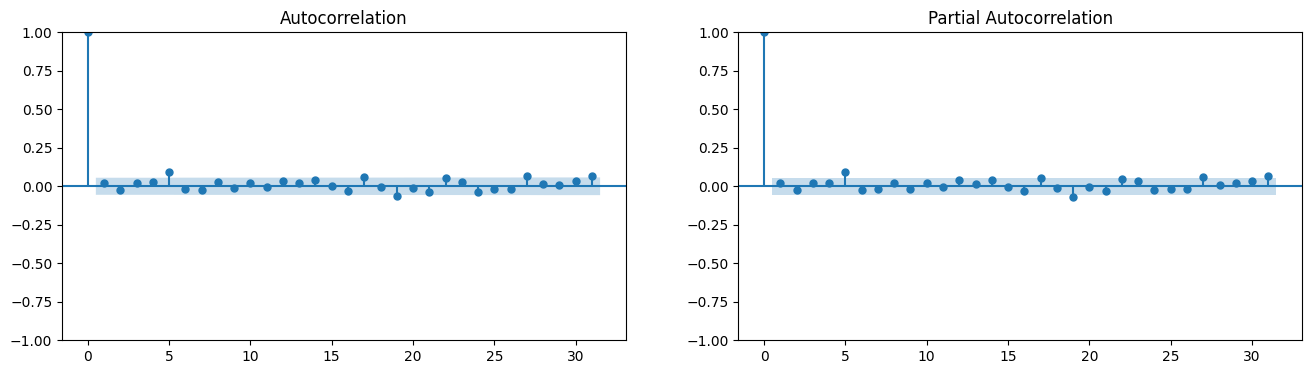

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ đồ thị ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(ssi_diff, ax=axes[0])
plot_pacf(ssi_diff, ax=axes[1])
plt.show()

Xác định p, q của mô hình Arima thì hai biểu đồ đều cho ra vị trí lag 0 là có sai phân lớn nhất cho nên bậc p và q là 0

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ssi_diff, order=(0, 1, 0))
arima_model = model.fit()

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1250
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -10275.535
Date:                Sat, 03 Aug 2024   AIC                          20553.070
Time:                        23:07:17   BIC                          20558.200
Sample:                             0   HQIC                         20554.998
                               - 1250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.186e+05   1.98e+04     41.392      0.000     7.8e+05    8.57e+05
Ljung-Box (L1) (Q):                 285.05   Jarque-Bera (JB):               683.53
Prob(Q):                              0.00   Pr

In [14]:
forecast_arima = arima_model.forecast(steps=len(test_series))

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_arima = mean_squared_error(test_series, forecast_arima, squared=False)
mae_arima = mean_absolute_error(test_series, forecast_arima)

print(f'RMSE: {rmse_arima}')
print(f'MAE: {mae_arima}')

RMSE: 50574.552520562436
MAE: 43513.250854700855


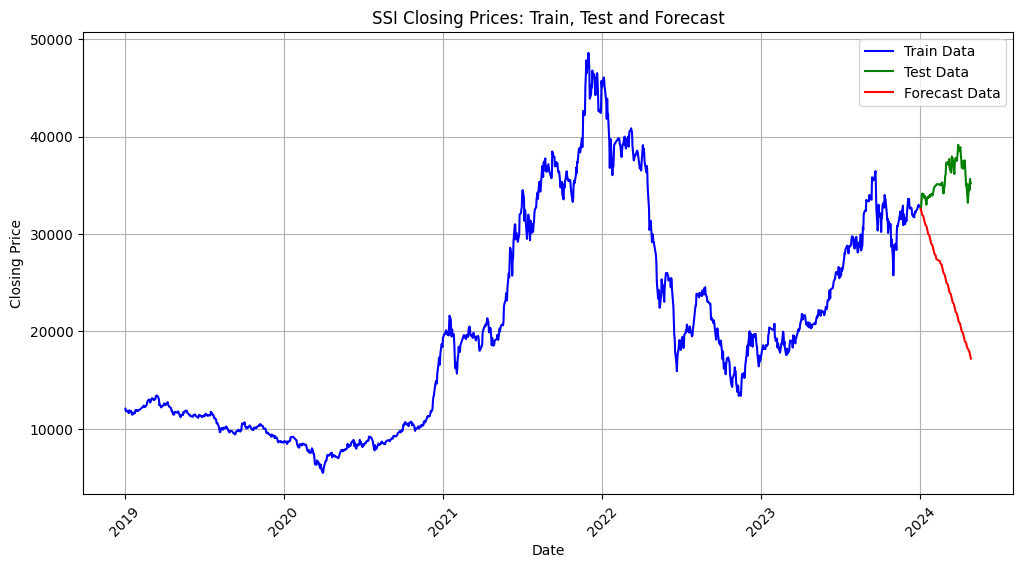

In [15]:
import matplotlib.pyplot as plt

# Thực hiện dự báo cho đúng số bước thời gian của tập dữ liệu test
forecast_steps = len(ssi_test_seri)
forecast_arima = arima_model.forecast(steps=forecast_steps)

forecast_cumsum = forecast_arima.cumsum()
forecast_restored = forecast_cumsum + ssi_train_seri.iloc[-1]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(ssi_train_seri.index, ssi_train_seri, label='Train Data', color='blue')
plt.plot(ssi_test_seri.index, ssi_test_seri, label='Test Data', color='green')
plt.plot(ssi_test_seri.index, forecast_restored, label='Forecast Data', color='red')
plt.title('SSI Closing Prices: Train, Test and Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#Thực hiện mô hình trên 30 mã

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Bước 1: Nạp dữ liệu
train_data = pd.read_csv('/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/data/ComVN30_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/data/ComVN30_test.csv')

# Lấy danh sách các mã chứng khoán
stock_codes = train_data['ticker'].unique()

# Khởi tạo dictionary để lưu trữ các mô hình
models = {}
orders = {}

# Khởi tạo list để lưu trữ RMSE và MAE
rmse_list = []
mae_list = []

# Hàm để tìm p, d, q tốt nhất sử dụng AIC
def find_best_arima_order(data, max_p=5, max_q=5):
    best_aic = float("inf")
    best_order = None
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(data, order=(p, 1, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, 1, q)
            except:
                continue
    return best_order

# Bước 2: Xây dựng mô hình ARIMA cho từng mã chứng khoán
for stock_code in stock_codes:
    # Dữ liệu huấn luyện
    df_train = train_data[train_data['ticker'] == stock_code].copy()
    df_train['time'] = pd.to_datetime(df_train['time'])
    df_train.set_index('time', inplace=True)
    df_train = df_train['close']

    # Dữ liệu kiểm thử
    df_test = test_data[test_data['ticker'] == stock_code].copy()
    df_test['time'] = pd.to_datetime(df_test['time'])
    df_test.set_index('time', inplace=True)
    df_test = df_test['close']

    # Kiểm tra tính dừng của chuỗi thời gian
    result = adfuller(df_train)
    if result[1] > 0.05:
        df_train_diff = df_train.diff().dropna()
    else:
        df_train_diff = df_train

    # Tìm p, q tốt nhất
    best_order = find_best_arima_order(df_train)
    print(f'{stock_code}: Best ARIMA order: {best_order}')

    # Ước lượng mô hình ARIMA
    model = ARIMA(df_train, order=best_order)
    model_fit = model.fit()
    models[stock_code] = model_fit
    orders[stock_code] = best_order

    # Dự báo trên dữ liệu kiểm thử
    forecast_steps = len(df_test)
    forecast = model_fit.forecast(steps=forecast_steps)

    # Khôi phục lại giá trị gốc của dự báo
    forecast_cumsum = forecast.cumsum()
    forecast_restored = forecast_cumsum + df_train.iloc[-1]


    rmse = mean_squared_error(df_test, forecast_restored, squared=False)
    mae = mean_absolute_error(df_test, forecast_restored)


    rmse_list.append((stock_code, rmse))
    mae_list.append((stock_code, mae))



print("\nRMSE cho từng mã chứng khoán:")
for stock_code, rmse in rmse_list:
    print(f'{stock_code}: {rmse}')

print("\nMAE cho từng mã chứng khoán:")
for stock_code, mae in mae_list:
    print(f'{stock_code}: {mae}')


SSI: Best ARIMA order: (5, 1, 5)
BCM: Best ARIMA order: (3, 1, 2)
VHM: Best ARIMA order: (2, 1, 2)
VIC: Best ARIMA order: (0, 1, 0)
VRE: Best ARIMA order: (2, 1, 2)
BVH: Best ARIMA order: (1, 1, 1)
POW: Best ARIMA order: (3, 1, 3)
GAS: Best ARIMA order: (3, 1, 5)
ACB: Best ARIMA order: (3, 1, 4)
BID: Best ARIMA order: (5, 1, 0)
CTG: Best ARIMA order: (2, 1, 3)
HDB: Best ARIMA order: (2, 1, 2)
MBB: Best ARIMA order: (2, 1, 3)
SSB: Best ARIMA order: (2, 1, 5)
SHB: Best ARIMA order: (4, 1, 2)
STB: Best ARIMA order: (2, 1, 5)
TCB: Best ARIMA order: (2, 1, 2)
TPB: Best ARIMA order: (2, 1, 2)
VCB: Best ARIMA order: (0, 1, 0)
VIB: Best ARIMA order: (5, 1, 4)
VPB: Best ARIMA order: (5, 1, 4)
HPG: Best ARIMA order: (5, 1, 3)
GVR: Best ARIMA order: (0, 1, 1)
MSN: Best ARIMA order: (2, 1, 2)
VNM: Best ARIMA order: (4, 1, 0)
SAB: Best ARIMA order: (2, 1, 3)
VJC: Best ARIMA order: (0, 1, 0)
MWG: Best ARIMA order: (2, 1, 4)
PLX: Best ARIMA order: (1, 1, 1)
FPT: Best ARIMA order: (2, 1, 3)

RMSE cho 

In [17]:
test_data['time'] = pd.to_datetime(test_data['time'])

In [19]:
import plotly.graph_objects as go
selected_stock_code = 'VJC'

if selected_stock_code in models:
    # Lấy dữ liệu huấn luyện tương ứng với mã đã chọn
    df_train = train_data[train_data['ticker'] == selected_stock_code].copy()
    df_train['time'] = pd.to_datetime(df_train['time'])
    df_train.set_index('time', inplace=True)
    df_train = df_train['close']

    # Huấn luyện mô hình trên dữ liệu train
    model_fit = models[selected_stock_code]

    # Dự báo dựa trên mô hình đã huấn luyện và dữ liệu train
    start_date = df_train.index[-1] + pd.Timedelta(days=1)
    end_date = start_date + pd.Timedelta(days=len(test_data) - 1)
    forecast_index = pd.date_range(start=start_date, end=end_date, freq='B')

    forecast = model_fit.predict(start=len(df_train), end=len(df_train) + len(test_data) - 1)

    forecast_cumsum = forecast.cumsum()
    forecast_restored = forecast_cumsum + df_train.iloc[-1]

    df_test = test_data[test_data['ticker'] == selected_stock_code].copy()


    # Đảm bảo cột 'time' là datetime và đặt làm index
    df_test['time'] = pd.to_datetime(df_test['time'])
    df_test.set_index('time', inplace=True)

    # Tạo biểu đồ sử dụng Plotly
    fig = go.Figure()

    # Dữ liệu huấn luyện
    fig.add_trace(go.Scatter(x=df_train.index, y=df_train, mode='lines', name='Train'))

    # Dữ liệu kiểm tra
    fig.add_trace(go.Scatter(x=df_test.index, y=df_test['close'], mode='lines', name='Test'))

    # Dữ liệu dự đoán
    fig.add_trace(go.Scatter(x=df_test.index, y=forecast, mode='lines', name='Forecast'))

    # Cấu hình hiển thị biểu đồ
    fig.update_layout(
        title=f'Dự báo giá đóng cửa của {selected_stock_code}',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis=dict(
            tickformat='%Y-%m-%d'
        ),
        legend=dict(x=0, y=1, traceorder='normal')
    )

    fig.show()
else:
    print(f'Mã {selected_stock_code} không tồn tại trong dữ liệu.')